<a href="https://colab.research.google.com/github/NeuromatchAcademy/course-content-dl/blob/NMACN2022/projects/Neuroscience/finetuning_fmri.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a> &nbsp; <a href="https://kaggle.com/kernels/welcome?src=https://raw.githubusercontent.com/NeuromatchAcademy/course-content-dl/NMACN2022/projects/Neuroscience/finetuning_fmri.ipynb" target="_parent"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" alt="Open in Kaggle"/></a>

# Moving beyond Labels: Finetuning CNNs on BOLD response

**By Neuromatch Academy**

__Content creators:__ Aakash Agrawal

__Production editors:__ Spiros Chavlis

<p align='center'><img src='https://github.com/NeuromatchAcademy/widgets/blob/master/sponsors.png?raw=True'/></p>

---
# Finetuning CNN using regression loss

- CNN are proven to be a better model of visual cortex, but the goal of visual cortex is not limited to image classification. 

- Typically, to model visual cortex responses using CNNs, we - 

  1. Extract features of intermediate layers
  2. Reduce dimensionality of the data using techniques like PCA
  3. Perform regression to predict neural data. 

- This approach fails to predict all the variance in the data.

**A better approach is to train CNNs directly on the neural response.**

---
# Setup

In [ ]:
# @title Install dependencies
!pip install Pillow --quiet
!pip install torch_intermediate_layer_getter --quiet

In [ ]:
#  Imports
import copy

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
from torch import nn, optim
from torch.utils.data import Dataset
from torch_intermediate_layer_getter import IntermediateLayerGetter as MidGetter

from torchvision import transforms
import torchvision.models as models


from scipy.spatial.distance import pdist
from scipy.stats import pearsonr

In [ ]:
# @title Downloading Kay dataset
import requests

fnames = ["kay_labels.npy", "kay_labels_val.npy", "kay_images.npz"]

urls =['https://osf.io/r638s/download',
       'https://osf.io/yqb3e/download',
       'https://osf.io/ymnjv/download']

for i, url in enumerate(urls):
  r = requests.get(url, allow_redirects=True)
  with open(fnames[i], 'wb') as fh:
    fh.write(r.content)


with np.load(fnames[2]) as dobj:
  dat = dict(**dobj)
labels = np.load('kay_labels.npy')
val_labels = np.load('kay_labels_val.npy')

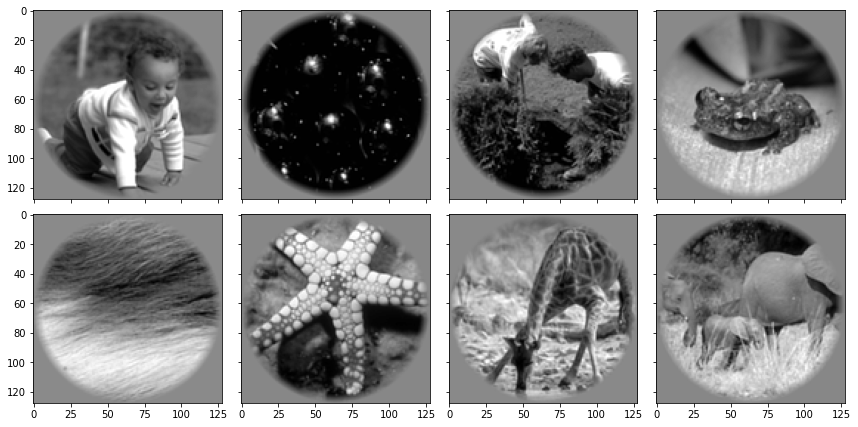

In [ ]:
# @title Visualizing example images
f, axs = plt.subplots(2, 4, figsize=(12, 6), sharex=True, sharey=True)
for ax, im in zip(axs.flat, dat["stimuli"]):
  ax.imshow(im, cmap="gray")
f.tight_layout()
plt.show()

---
# Dataset Structure

`dat` has the following fields:  
- `stimuli`: stim $x_i \, \, x_j$ array of grayscale stimulus images
- `stimuli_test`: stim $x_i \, \, x_j$ array of grayscale stimulus images in the test set  
- `responses`: stim $x$ voxel array of $z$-scored BOLD response amplitude
- `responses_test`:  stim $x$ voxel array of $z$-scored BOLD response amplitude in the test set  
- `roi`: array of voxel labels
- `roi_names`: array of names corresponding to voxel labels

In [ ]:
# Converting stimulus to RGB and changing the scale to 0-255 (Specific to Kay dataset images)
stimuli_tr = dat["stimuli"]
stimuli_ts = dat["stimuli_test"]
stimuli_tr_xformed = np.zeros((1750, 3, 128, 128))
stimuli_ts_xformed = np.zeros((120, 3, 128, 128))
for i in range(1750):
  img = stimuli_tr[i, :, :]
  img = ((img - np.min(img))*255/(np.max(img) - np.min(img))).astype(int)
  stimuli_tr_xformed[i, :, :, :] = [img,img,img]

for i in range(120):
  img = stimuli_ts[i, :, :]
  img = ((img - np.min(img))*255/(np.max(img) - np.min(img))).astype(int)
  stimuli_ts_xformed[i, :, :, :] = [img, img, img]

---
# Fine Tuning AlexNet on voxel activations





In [ ]:
# @title Setting up training and test data for LOC region
loc_id = np.where(dat['roi'] == 7)
response_tr = np.squeeze(dat["responses"][:, loc_id])
response_ts = np.squeeze(dat["responses_test"][:, loc_id])

In [ ]:
# @title Custom dataloader for loading images in numpy array
class MyDataset(Dataset):
  def __init__(self, data, targets, transform=None):
    self.data = data
    self.targets = torch.LongTensor(targets)
    self.transform = transform

  def __getitem__(self, index):
    x = self.data[index]
    y = self.targets[index]

    if self.transform:
        x = Image.fromarray(self.data[index].astype(np.uint8).transpose(1, 2, 0))
        x = self.transform(x)

    return x, y

  def __len__(self):
      return len(self.data)


transform = {
    'train': transforms.Compose([
                                 transforms.RandomResizedCrop(224),
                                 transforms.RandomHorizontalFlip(),
                                 transforms.ToTensor(),
                                 transforms.Normalize([0.485, 0.456, 0.406],
                                                      [0.229, 0.224, 0.225])
                                 ]),
    'val': transforms.Compose([
                               transforms.Resize(256),
                               transforms.CenterCrop(224),
                               transforms.ToTensor(),
                               transforms.Normalize([0.485, 0.456, 0.406],
                                                    [0.229, 0.224, 0.225])
                               ]),
             }

dataset = {}
dataset['train'] = MyDataset(list(stimuli_tr_xformed),
                             list(response_tr), transform=transform['train'])
dataset['val'] = MyDataset(list(stimuli_ts_xformed),
                           list(response_ts), transform=transform['val'])
dataset_sizes = {x: len(dataset[x]) for x in ['train', 'val']}

dataloaders = {x: torch.utils.data.DataLoader(dataset[x], batch_size=50) for x in ['train', 'val']}
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
# Training
net = models.alexnet(pretrained=True)
num_ftrs = net.classifier[6].in_features
net.classifier[6] = nn.Linear(num_ftrs, np.shape(response_ts)[1])

net.to(device)
criterion = nn.MSELoss()
learning_rate = 0.1  # Change this
num_epochs =  5  # Change this
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)



best_model_wts = copy.deepcopy(net.state_dict())
best_loss = 10.0

for epoch in range(num_epochs):
	print(f"Epoch {epoch}/{num_epochs - 1}")
	print('-' * 20)

	# Each epoch has a training and validation phase
	for phase in ['train', 'val']:
		if phase == 'train':
			net.train()  # Set model to training mode
		else:
			net.eval()   # Set model to evaluate mode

		running_loss = 0.0
		running_corrects = 0

		# Iterate over data.
		for inputs, labels in dataloaders[phase]:
			inputs = inputs.to(device)
			labels = labels.to(device)

			# zero the parameter gradients
			optimizer.zero_grad()

			# forward
			# track history if only in train
			with torch.set_grad_enabled(phase == 'train'):
				outputs = net(inputs)
				loss = criterion(outputs.float(), labels.float())

				# backward + optimize only if in training phase
				if phase == 'train':
					loss.backward()
					optimizer.step()

			# statistics
			running_loss += loss.item() * inputs.size(0)

		epoch_loss = running_loss / dataset_sizes[phase]
		print(f"{phase} Loss: {epoch_loss:.4f}")

		# deep copy the model
		if phase == 'val' and epoch_loss < best_loss:
			best_loss = epoch_loss
			best_model_wts = copy.deepcopy(net.state_dict())

	print()

# load best model weights
net.load_state_dict(best_model_wts)

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth



Epoch 0/4
--------------------


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


train Loss: 0.4805
val Loss: 0.0503

Epoch 1/4
--------------------
train Loss: 0.4680
val Loss: 0.0503

Epoch 2/4
--------------------
train Loss: 0.4679
val Loss: 0.0501

Epoch 3/4
--------------------
train Loss: 0.4677
val Loss: 0.0500

Epoch 4/4
--------------------
train Loss: 0.4677
val Loss: 0.0499



<All keys matched successfully>

In [ ]:
## Extract features of all the intermediate layers from ImageNet-trained and finetuned Alexnet
return_layers = {
    'features.2': 'conv1',
    'features.5': 'conv2',
    'features.7': 'conv3',
    'features.9': 'conv4',
    'features.12': 'conv5',
    'classifier.1': 'fc1',
    'classifier.4': 'fc2',
    'classifier.6': 'fc3',
    }

# Loading AlexNet pretrained on Imagenet
net_im = models.alexnet(pretrained=True)
net_im.eval()
net_im.to(device)


# Setting up feature extraction step
midfeat_ft = MidGetter(net, return_layers=return_layers, keep_output=True)
midfeat_im = MidGetter(net_im, return_layers=return_layers, keep_output=True)

# Loading validation data and forward pass through the network
dataloaders = {x: torch.utils.data.DataLoader(dataset[x], batch_size=120) for x in ['val']}
for inputs, labels in dataloaders['val']:
  inputs = inputs.to(device)
  mid_outputs_ft, _ = midfeat_ft(inputs)
  mid_outputs_im, _ = midfeat_im(inputs)

In [ ]:
# @title Dissimilarity - Correlation
# Loading V1 and LOC responses
v1_id = np.where(dat['roi'] == 1)
loc_id = np.where(dat['roi'] == 7)
Rts_v1 = np.squeeze(dat["responses_test"][:, v1_id])
Rts_lo = np.squeeze(dat["responses_test"][:, loc_id])

# Observed dissimilarity  - Correlation
fMRI_dist_metric_ft = "euclidean"  # ['correlation', 'euclidean']
fMRI_dist_metric_im = "correlation"  # ['correlation', 'euclidean']

Alexnet_ft_dist_metric = "euclidean"  # ['correlation', 'euclidean']
Alexnet_im_dist_metric = "correlation"  # ['correlation', 'euclidean']

dobs_v1_ft = pdist(Rts_v1, fMRI_dist_metric_ft)
dobs_lo_ft = pdist(Rts_lo, fMRI_dist_metric_ft)
dobs_v1_im = pdist(Rts_v1, fMRI_dist_metric_im)
dobs_lo_im = pdist(Rts_lo, fMRI_dist_metric_im)

# Comparing representation of V1 and LOC across different layers of Alexnet
r, p = np.zeros((4, 8)), np.zeros((4, 8))
for i,l in enumerate(mid_outputs_ft.keys()):
  dnet_ft = pdist(torch.flatten(mid_outputs_ft[l], 1, -1).cpu().detach().numpy(),
                  Alexnet_ft_dist_metric)
  dnet_im = pdist(torch.flatten(mid_outputs_im[l], 1, -1).cpu().detach().numpy(),
                  Alexnet_im_dist_metric)
  r[0, i], p[0, i] = pearsonr(dnet_ft, dobs_v1_ft)
  r[1, i], p[1, i] = pearsonr(dnet_im, dobs_v1_im)
  r[2, i], p[2, i] = pearsonr(dnet_ft, dobs_lo_ft)
  r[3, i], p[3, i] = pearsonr(dnet_im, dobs_lo_im)

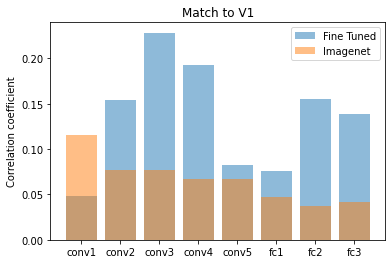

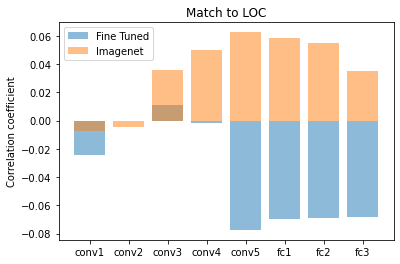

In [ ]:
# @title Plotting correlation between observed and predicted dissimilarity values
plt.bar(range(8), r[0, :], alpha=0.5)
plt.bar(range(8), r[1, :], alpha=0.5)
plt.legend(['Fine Tuned', 'Imagenet'])
plt.ylabel('Correlation coefficient')
plt.title('Match to V1')
plt.xticks(range(8), mid_outputs_ft.keys())
plt.show()

plt.figure()
plt.bar(range(8), r[2, :], alpha=0.5)
plt.bar(range(8), r[3, :], alpha=0.5)
plt.legend(['Fine Tuned', 'Imagenet'])
plt.ylabel('Correlation coefficient')
plt.title('Match to LOC')
plt.xticks(range(8), mid_outputs_ft.keys())
plt.show()